In [2]:
# 出一个舟山北部水域的航迹图
# 已解析数据-舟山北部数据-1月

import os

def file_name(file_dir):
    L = []
    for root, dirs, files in os.walk(file_dir):  
        for file in files:  
            L.append(os.path.join(root, file))  
    return L 

# 读取当前路径下的所有txt文件
path = '.\\test_folder'
path1 = 'E:\\已解析AIS数据\\舟山北部水域\\1月上'
path2 = 'E:\\已解析AIS数据\\舟山北部水域\\1月下'

L = file_name(path1) + file_name(path2)

In [3]:
# 整理所有的经纬度和MMSI
X = []
Y = []
MMSI = []
#range后改成15
for i in range(15):
    f = open(L[i])
    for line in f.readlines():
        data = line.split(',')
        MMSI.append(data[1])
        X.append(float(data[2]))
        Y.append(float(data[3]))


length = len(MMSI)
length #30688026

30688026

In [4]:
# 根据14个bound开始MMSI匹配
MMSI_bound = []
for i in range(14):
    MMSI_bound.append([])

# 匹配函数
def isinpolygon(point,vertex_lst:list, contain_boundary=True):
    #检测点是否位于区域外接矩形内
    lngaxis, lataxis = zip(*vertex_lst)
    minlng, maxlng = min(lngaxis),max(lngaxis)
    minlat, maxlat = min(lataxis),max(lataxis)
    lng, lat = point
    if contain_boundary:      
        isin = (minlng<=lng<=maxlng) & (minlat<=lat<=maxlat)
    else:
        isin = (minlng<lng<maxlng) & (minlat<lat<maxlat)
    return isin

def isintersect(poi,spoi,epoi):
    #输入：判断点，边起点，边终点，都是[lng,lat]格式数组
    #射线为向东的纬线
    #可能存在的bug，当区域横跨本初子午线或180度经线的时候可能有问题
    lng, lat = poi
    slng, slat = spoi
    elng, elat = epoi
    if poi == spoi:
        #print("在顶点上")
        return None
    if slat==elat: #排除与射线平行、重合，线段首尾端点重合的情况
        return False
    if slat>lat and elat>lat: #线段在射线上边
        return False
    if slat<lat and elat<lat: #线段在射线下边
        return False
    if slat==lat and elat>lat: #交点为下端点，对应spoint
        return False
    if elat==lat and slat>lat: #交点为下端点，对应epoint
        return False
    if slng<lng and elat<lat: #线段在射线左边
        return False
    #求交点
    xseg=elng-(elng-slng)*(elat-lat)/(elat-slat)
    if xseg == lng:
        #print("点在多边形的边上")
        return None
    if xseg<lng: #交点在射线起点的左侧
        return False
    return True  #排除上述情况之后

def isin_multipolygon(poi,vertex_lst, contain_boundary=True): 
    # 判断是否在外包矩形内，如果不在，直接返回false    
    if not isinpolygon(poi, vertex_lst, contain_boundary):
        return False
    sinsc = 0        
    for spoi, epoi in zip(vertex_lst[:-1],vertex_lst[1::]):
        intersect = isintersect(poi, spoi, epoi)
        if intersect is None:
            return (False, True)[contain_boundary]
        elif intersect:
            sinsc+=1          
    return sinsc%2==1

def inStrict(poi,MMSI):
    '''
    poi是当前的点坐标，i是当前区域的选择
    '''
    # 14个bound
    bound = [
        [[30.4729,122.5297],[30.4635,122.5420],[30.4374,122.5400],[30.4499,122.5818],[30.4729,122.5297]],  #区域1
        [[30.4504,122.6381],[30.4504,122.6924],[30.4303,122.6281],[30.4303,122.6381],[30.4504,122.6381]],  #区域2
        [[30.4990,122.4294],[30.4990,122.4610],[30.4854,122.4301],[30.4854,122.4610],[30.4990,122.4294]],  #区域3
        [[30.4368,122.4322],[30.4368,122.4514],[30.4309,122.4322],[30.4309,122.5414],[30.4368,122.4322]],  #区域4
        [[30.4398,122.4253],[30.4339,122.4391],[30.4410,122.4267],[30.4351,122.4404],[30.4398,122.4253]],  #区域5
        [[30.4161,122.4233],[30.4232,122.4270],[30.4173,122.4288],[30.4232,122.4397],[30.4161,122.4233]],  #区域6
        [[30.3918,122.4343],[30.3918,122.4597],[30.3847,122.4343],[30.3847,422.4597],[30.3918,122.4343]],  #区域7
        [[30.4179,122.5050],[30.4291,122.5160],[30.4185,122.5029],[30.4303,122.5160],[30.4179,122.5050]],  #区域8
        [[30.4037,122.5009],[30.3871,122.5105],[30.4031,122.5002],[30.3841,122.5098],[30.4037,122.5009]],  #区域9
        [[30.4291,122.5359],[30.4090,122.5537],[30.4268,122.5345],[30.4078,122.5476],[30.4291,122.5359]],  #区域10
        [[30.4268,122.6897],[30.4457,122.7075],[30.4262,122.6862],[30.4516,122.6979],[30.4268,122.6897]],  #区域11
        [[30.5357,122.4370],[30.5357,122.4343],[30.5179,122.4370],[30.5215,122.4343],[30.5357,122.4370]],  #区域12
        [[30.3770,122.7700],[30.3723,122.8290],[30.3670,122.7837],[30.3652,122.8290],[30.3770,122.7700]],  #区域13
        [[30.3658,122.5688],[30.3640,122.6045],[30.3616,122.5516],[30.3572,122.6045],[30.3658,122.5688]]   #区域14
    ]

    for i in range(14):
        if isin_multipolygon(poi,bound[i], contain_boundary=True):
            #print("I am in!")
            # 将当前的MMSI添加进对应list
            MMSI_bound[i].append(MMSI)

for i in range(length):
    inStrict([Y[i],X[i]], MMSI[i])

In [5]:
# 输出每个区域的船舶数量
for i in range(14):
    print(str(i) + " : " + str(len(MMSI_bound[i])))

0 : 14257
1 : 9983
2 : 7322
3 : 3122
4 : 5047
5 : 146
6 : 1639
7 : 24
8 : 1258
9 : 3056
10 : 552
11 : 1845
12 : 6074
13 : 3617


In [19]:
# 匹配代码——希望一次就能成功过80%大关！！！
# 读取静态表格
import csv
import pandas as pd

path2 = r'./mmsi.csv'

datas = pd.read_csv(path2)
data = datas.values

olength = data.shape[0]

for i in range(14):
    num = 0 #区域匹配计数
    filename = ".\\OUTPUT\\Bound_" + str(i+1) + ".csv"
    #print(filename)
    ff = open(filename,'a',encoding='utf-8',newline='' "")
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(ff)
    # 3. 构建列表头
    csv_writer.writerow(["MMSI", "shiptype","length","width"])
    # 下方之后修改成循环写入
    #MMSI_b = list(set(MMSI_bound[i]))
    MMSI_b = MMSI_bound[i]
    mlength = len(MMSI_b)
    #print(mlength)
    for j in range(mlength):
        flag = 1
        for k in range(olength):
            try:
                if int(MMSI_b[j]) == int(data[k][0]):
                    #print("bingo!")
                    num += 1
                    csv_writer.writerow([int(data[k][0]), data[k][1], data[k][2], data[k][3]])
                    flag = 0
                    break
            except:
                continue
        if flag:
            csv_writer.writerow([MMSI_b[j]])
    print("区域" + str(i+1) + "匹配率：" + str(num/mlength))
    ff.close()


区域1匹配率：0.9414322788805499
区域2匹配率：0.9399979965942101
区域3匹配率：0.8791313848675225
区域4匹配率：0.8526585522101218
区域5匹配率：0.9750346740638003
区域6匹配率：0.9383561643835616
区域7匹配率：0.8926174496644296
区域8匹配率：0.9166666666666666
区域9匹配率：0.958664546899841
区域10匹配率：0.955824607329843
区域11匹配率：0.9311594202898551
区域12匹配率：0.8428184281842819
区域13匹配率：0.31824168587421797
区域14匹配率：0.9239701410008294


In [20]:
# 船型统计
temp = 14
for j in range(temp):
    # 初始化统计list
    list = [0 for i in range(5)]
    filename = ".\\OUTPUT\\Bound_" + str(j+1) + ".csv"
    datas = pd.read_csv(filename)
    data = datas.values
    tlength = data.shape[0]
    for i in range(tlength):
        #print(data[i][1])
        if data[i][1] == 0:
            list[0] += 1
        elif 80 <= data[i][1] and data[i][1] <= 89:
            list[3] += 1
        elif 70 <= data[i][1] and data[i][1] <= 79:
            list[2] += 1
        elif 60 <= data[i][1] and data[i][1] <= 69:
            list[1] += 1
        else:
            list[4] += 1
    print("第" + str(j+1) + "个区域：" + str(list))  


第1个区域：[52, 67, 9341, 198, 4599]
第2个区域：[9, 379, 2821, 1398, 5376]
第3个区域：[110, 0, 2508, 74, 4630]
第4个区域：[39, 2, 870, 37, 2174]
第5个区域：[16, 61, 231, 39, 4700]
第6个区域：[3, 0, 17, 0, 126]
第7个区域：[38, 0, 343, 139, 1119]
第8个区域：[0, 0, 16, 0, 8]
第9个区域：[0, 0, 568, 72, 618]
第10个区域：[4, 0, 1349, 39, 1664]
第11个区域：[7, 5, 36, 43, 461]
第12个区域：[4, 0, 605, 58, 1178]
第13个区域：[31, 0, 142, 18, 5883]
第14个区域：[28, 1, 2781, 144, 663]


In [9]:
list = [0 for i in range(5)]
print(list)

[0, 0, 0, 0, 0]


NameError: name 'X' is not defined

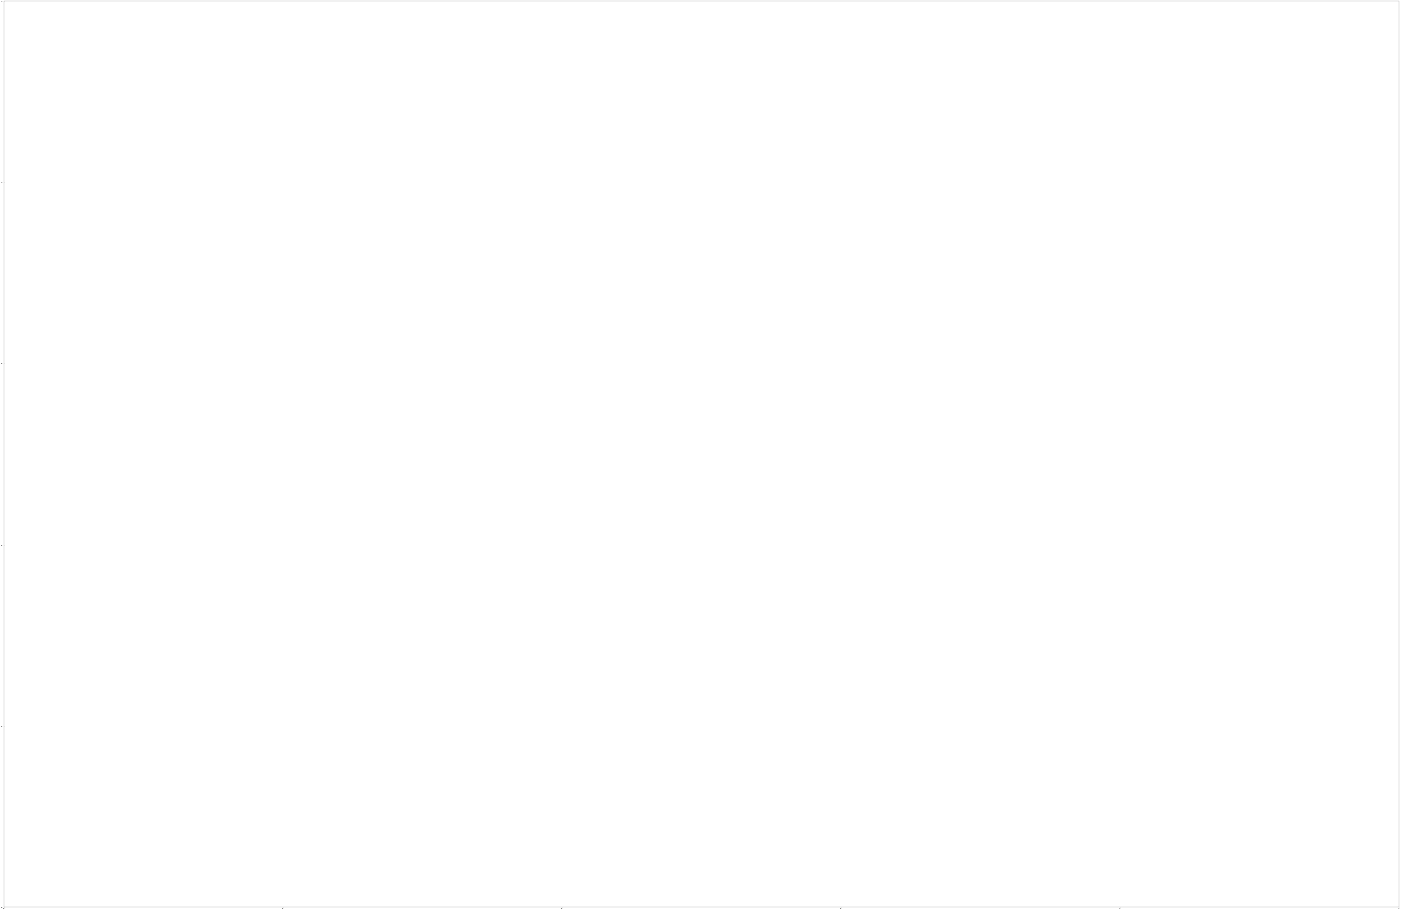

In [1]:
#！！！！！我终于画完底图了
#定义显示范围范围
bounds = [121.9043,30.2666,122.973,30.81413]

#创建图框
import matplotlib.pyplot as plt
import plot_map

fig =plt.figure(1,(180,120),dpi=10)
ax =plt.subplot(111)
# 绘制散点
ax.scatter(X[:1000],Y[:1000],c='r',s=10,marker='v')
plt.sca(ax)
#添加地图底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)
plt.scatter(X,Y,c='cornflowerblue',alpha=0.01)
#添加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
#plt.axis('off')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()